In [1]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

from event_clustering.preprocessing import *
from event_clustering.clustering import *
from event_clustering.feature_engineering import *
from event_clustering.postprocessing import *
from event_clustering.process_mining import *

from sklearn.cluster import *
import sklearn.metrics as metrics

# Loading Preprocessing Analyzing

In [40]:
file_path = 'data/DomesticDeclarations.xes'
df = preprocess(load(file_path))

In [4]:
analyze(df)
df.head(10)

column name: case:Amount
data type: <class 'numpy.float64'>
unique values: 8326


column name: case:BudgetNumber
data type: <class 'str'>
unique values: 1


column name: case:DeclarationNumber
data type: <class 'str'>
unique values: 10049


column name: case:concept:name
data type: <class 'str'>
unique values: 10500


column name: case:id
data type: <class 'str'>
unique values: 10500


column name: concept:name
data type: <class 'str'>
unique values: 17


column name: id
data type: <class 'str'>
unique values: 56437


column name: org:resource
data type: <class 'str'>
unique values: 2


column name: org:role
data type: <class 'str'>
unique values: 7


column name: time:timestamp
data type: <class 'datetime.datetime'>
unique values: 45403




,case:Amount,case:BudgetNumber,case:DeclarationNumber,case:concept:name,case:id,concept:name,id,org:resource,org:role,time:timestamp
0,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration SUBMITTED by EMPLOYEE,st_step 86794_0,STAFF MEMBER,EMPLOYEE,2017-01-09 09:49:50+01:00
1,182.464172,budget 86566,declaration number 86796,declaration 86795,declaration 86795,Declaration SUBMITTED by EMPLOYEE,st_step 86798_0,STAFF MEMBER,EMPLOYEE,2017-01-09 10:26:14+01:00
2,320.646137,budget 86566,declaration number 86801,declaration 86800,declaration 86800,Declaration SUBMITTED by EMPLOYEE,st_step 86804_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:13:33+01:00
3,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration SUBMITTED by EMPLOYEE,st_step 86733_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:24:20+01:00
4,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86793_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:27:48+01:00
5,134.404169,budget 86566,declaration number 86736,declaration 86735,declaration 86735,Declaration SUBMITTED by EMPLOYEE,st_step 86738_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:30:26+01:00
6,134.404169,budget 86566,declaration number 86736,declaration 86735,declaration 86735,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86737_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:37:18+01:00
7,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86734_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:37:23+01:00
8,443.585163,budget 86566,declaration number 86806,declaration 86805,declaration 86805,Declaration SUBMITTED by EMPLOYEE,st_step 86807_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:40:47+01:00
9,443.585163,budget 86566,declaration number 86806,declaration 86805,declaration 86805,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86808_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:41:23+01:00


In [41]:
df = df[:1000]

# Feature Generation

In [43]:
add_event_type_representative(df)

,case:Amount,case:BudgetNumber,case:DeclarationNumber,case:concept:name,case:id,concept:name,id,org:resource,org:role,time:timestamp,concept:name_representative
0,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration SUBMITTED by EMPLOYEE,st_step 86794_0,STAFF MEMBER,EMPLOYEE,2017-01-09 09:49:50+01:00,A
1,182.464172,budget 86566,declaration number 86796,declaration 86795,declaration 86795,Declaration SUBMITTED by EMPLOYEE,st_step 86798_0,STAFF MEMBER,EMPLOYEE,2017-01-09 10:26:14+01:00,A
2,320.646137,budget 86566,declaration number 86801,declaration 86800,declaration 86800,Declaration SUBMITTED by EMPLOYEE,st_step 86804_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:13:33+01:00,A
3,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration SUBMITTED by EMPLOYEE,st_step 86733_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:24:20+01:00,A
4,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86793_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:27:48+01:00,B
5,134.404169,budget 86566,declaration number 86736,declaration 86735,declaration 86735,Declaration SUBMITTED by EMPLOYEE,st_step 86738_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:30:26+01:00,A
6,134.404169,budget 86566,declaration number 86736,declaration 86735,declaration 86735,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86737_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:37:18+01:00,B
7,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86734_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:37:23+01:00,B
8,443.585163,budget 86566,declaration number 86806,declaration 86805,declaration 86805,Declaration SUBMITTED by EMPLOYEE,st_step 86807_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:40:47+01:00,A
9,443.585163,budget 86566,declaration number 86806,declaration 86805,declaration 86805,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86808_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:41:23+01:00,B


In [44]:
# todo, maybe replace concept name column with a representative
add_previous_event_reference(df, 3)
add_next_event_reference(df, 3)

,case:Amount,case:BudgetNumber,case:DeclarationNumber,case:concept:name,case:id,concept:name,id,org:resource,org:role,time:timestamp,concept:name_representative,feature_previous_concept:name_representative_-1,feature_previous_concept:name_representative_-2,feature_previous_concept:name_representative_-3,feature_next_concept:name_representative_+1,feature_next_concept:name_representative_+2,feature_next_concept:name_representative_+3
0,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration SUBMITTED by EMPLOYEE,st_step 86794_0,STAFF MEMBER,EMPLOYEE,2017-01-09 09:49:50+01:00,A,start,,,B,C,G
1,182.464172,budget 86566,declaration number 86796,declaration 86795,declaration 86795,Declaration SUBMITTED by EMPLOYEE,st_step 86798_0,STAFF MEMBER,EMPLOYEE,2017-01-09 10:26:14+01:00,A,start,,,end,,
2,320.646137,budget 86566,declaration number 86801,declaration 86800,declaration 86800,Declaration SUBMITTED by EMPLOYEE,st_step 86804_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:13:33+01:00,A,start,,,F,B,C
3,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration SUBMITTED by EMPLOYEE,st_step 86733_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:24:20+01:00,A,start,,,B,C,G
4,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86793_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:27:48+01:00,B,A,start,,C,G,end
5,134.404169,budget 86566,declaration number 86736,declaration 86735,declaration 86735,Declaration SUBMITTED by EMPLOYEE,st_step 86738_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:30:26+01:00,A,start,,,B,C,G
6,134.404169,budget 86566,declaration number 86736,declaration 86735,declaration 86735,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86737_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:37:18+01:00,B,A,start,,C,G,end
7,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86734_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:37:23+01:00,B,A,start,,C,G,end
8,443.585163,budget 86566,declaration number 86806,declaration 86805,declaration 86805,Declaration SUBMITTED by EMPLOYEE,st_step 86807_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:40:47+01:00,A,start,,,B,C,G
9,443.585163,budget 86566,declaration number 86806,declaration 86805,declaration 86805,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86808_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:41:23+01:00,B,A,start,,C,G,end


In [6]:
add_timestamp_features(df)

# Encoding

In [7]:
df_cn = tfidf_encode(df, 'concept:name', TfidfVectorizer(stop_words = 'english'))
df_role = one_hot_encode(df, 'org:role')

In [8]:
df_vectorized = df_cn
df_vectorized = df_vectorized.join(df_role)
#df_vectorized = df_vectorized.join(df['feature_day_nr'])

# Clustering + Evaluation

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters


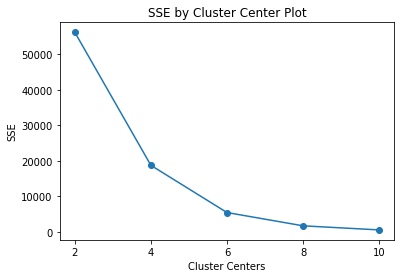

In [9]:
find_optimal_clusters(df_vectorized, 10)

In [10]:
km = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20)
clusters = km.fit_predict(df_vectorized)

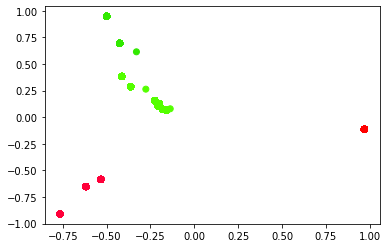

In [11]:
plot_pca(df_vectorized, clusters)

In [12]:
metrics.silhouette_score(df_vectorized, clusters)

0.7592794731195295

In [13]:
# set cluster label as a column in the original df
df = add_cluster_label(df, df_vectorized, km)
df.head(5)

,case:Amount,case:BudgetNumber,case:DeclarationNumber,case:concept:name,case:id,concept:name,id,org:resource,org:role,time:timestamp,feature_day_nr,feature_weekday,feature_hour,cluster_label
0,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration SUBMITTED by EMPLOYEE,st_step 86794_0,STAFF MEMBER,EMPLOYEE,2017-01-09 09:49:50+01:00,0,0,9,2
1,182.464172,budget 86566,declaration number 86796,declaration 86795,declaration 86795,Declaration SUBMITTED by EMPLOYEE,st_step 86798_0,STAFF MEMBER,EMPLOYEE,2017-01-09 10:26:14+01:00,0,0,10,2
2,320.646137,budget 86566,declaration number 86801,declaration 86800,declaration 86800,Declaration SUBMITTED by EMPLOYEE,st_step 86804_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:13:33+01:00,0,0,11,2
3,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration SUBMITTED by EMPLOYEE,st_step 86733_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:24:20+01:00,0,0,11,2
4,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86793_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:27:48+01:00,0,0,11,1


In [42]:
# TODO: check which events are in which cluster!

In [41]:
# overwrite concept:name with mapped cluster representative
abstracted_df = replace_with_representative(df, "concept:name_representative", "cluster_label")
abstracted_df.head(5)

,case:Amount,case:BudgetNumber,case:DeclarationNumber,case:concept:name,case:id,concept:name,id,org:resource,org:role,time:timestamp
0,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,C,st_step 86794_0,STAFF MEMBER,EMPLOYEE,2017-01-09 09:49:50+01:00
1,182.464172,budget 86566,declaration number 86796,declaration 86795,declaration 86795,C,st_step 86798_0,STAFF MEMBER,EMPLOYEE,2017-01-09 10:26:14+01:00
2,320.646137,budget 86566,declaration number 86801,declaration 86800,declaration 86800,C,st_step 86804_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:13:33+01:00
3,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,C,st_step 86733_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:24:20+01:00
4,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,B,st_step 86793_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:27:48+01:00


In [48]:
# write abstracted dataframe as csv file
csv_filename = "data/abstracted_df_domestic_declarations.csv"
write_to_csv(abstracted_df, csv_filename, index=False)

Finished writing to CSV file.


# Compare Process Models from Original Dataset to Abstracted Dataset

In [52]:
# read original and abstracted dataset as event logs
filepath_original = "data/DomesticDeclarations.xes"
filepath_abstracted = csv_filename

original_log = read_as_log_xes(filepath_original)
abstracted_log = read_as_log_csv(filepath_abstracted)

print("Original Log:")
print(original_log)
print("\nAbstracted Log:")
print(abstracted_log)

Original Log:
[{'attributes': {'id': 'declaration 86791', 'concept:name': 'declaration 86791', 'BudgetNumber': 'budget 86566', 'DeclarationNumber': 'declaration number 86792', 'Amount': 26.85120450862128}, 'events': [{'id': 'st_step 86794_0', 'org:resource': 'STAFF MEMBER', 'concept:name': 'Declaration SUBMITTED by EMPLOYEE', 'time:timestamp': datetime.datetime(2017, 1, 9, 9, 49, 50, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'org:role': 'EMPLOYEE'}, '..', {'id': 'dd_declaration 86791_20', 'org:resource': 'SYSTEM', 'concept:name': 'Payment Handled', 'time:timestamp': datetime.datetime(2017, 1, 12, 17, 31, 22, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'org:role': 'UNDEFINED'}]}, '....', {'attributes': {'id': 'declaration 138359', 'concept:name': 'declaration 138359', 'BudgetNumber': 'budget 86566', 'DeclarationNumber': 'declaration number 138360', 'Amount': 190.40457573396148}, 'events': [{'id': 'st_step 138363_0', 'org:resource': 'STAFF MEMBER', 'co

## Mining Algorithms
* Alpha Miner
* Inductive Miner
* Heuristic Miner
* Directly-Follows Graph

In [ ]:
# Alpha Miner
net_alpha_orig, im_alpha_orig, fm_alpha_orig = a_miner(original_log)
net_alpha, im_alpha, fm_alpha = a_miner(abstracted_log)

In [ ]:
# Inductive Miner
net_ind_orig, im_ind_orig, fm_ind_orig = ind_miner(original_log)
net_ind, im_ind, fm_ind = ind_miner(abstracted_log)

In [ ]:
# Heuristic Miner
net_heu_orig, im_heu_orig, fm_heu_orig = heu_miner(original_log)
net_heu, im_heu, fm_heu = heu_miner(abstracted_log)

In [ ]:
# Directly-Follows Graph
dfg_miner(original_log)
dfg_miner(abstracted_log)

## Process Model Metrics
* Fitness
* Precision
* Generalization
* Simplicity

In [88]:
# Fitness
print("Original Log with Heuristic Miner:")
fitness_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
fitness_metric(abstracted_log, net_heu, im_heu, fm_heu)

Fitness = {'percFitTraces': 33.8, 'averageFitness': 0.889158168968773}
Fitness = {'percFitTraces': 3.2095238095238097, 'averageFitness': 0.6970055341501722}


In [90]:
# Precision
print("Original Log with Heuristic Miner:")
precision_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
precision_metric(abstracted_log, net_heu, im_heu, fm_heu)

Original Log with Heuristic Miner:
Precision =  0.8627950290951565

Abstracted Log with Heuristic Miner
Precision =  0.773403383137852


In [91]:
# Generalization
print("Original Log with Heuristic Miner:")
generalization_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
generalization_metric(abstracted_log, net_heu, im_heu, fm_heu)

Original Log with Heuristic Miner:
Generalization =  0.8505132359451776

Abstracted Log with Heuristic Miner
Generalization =  0.9591036742979986


In [94]:
# Simplicity
print("Original Log with Heuristic Miner:")
simplicity_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
simplicity_metric(abstracted_log, net_heu, im_heu, fm_heu)

Original Log with Heuristic Miner:
Simplicity =  0.8627950290951565

Abstracted Log with Heuristic Miner
Simplicity =  0.773403383137852


In [93]:
# Evaluation --> all four metrices in one line
print("Original Log with Heuristic Miner:")
evaluation_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
evaluation_metric(abstracted_log, net_heu, im_heu, fm_heu)

Original Log with Heuristic Miner:
Evaluation =  {'fitness': {'perc_fit_traces': 33.8, 'average_trace_fitness': 0.9122910864684509, 'log_fitness': 0.9318636709168088}, 'precision': 0.8615982766773499, 'generalization': 0.8505132359451776, 'simplicity': 0.7804878048780488, 'metricsAverageWeight': 0.8561157471043463, 'fscore': 0.8953545226172118}

Abstracted Log with Heuristic Miner
Evaluation =  {'fitness': {'perc_fit_traces': 3.2095238095238097, 'average_trace_fitness': 0.9073998870234264, 'log_fitness': 0.906771374948023}, 'precision': 0.773403383137852, 'generalization': 0.9591036742979986, 'simplicity': 0.7454545454545455, 'metricsAverageWeight': 0.8461832444596048, 'fscore': 0.8347941733350558}
